In [1]:
import rebound, numpy as np, matplotlib as mpl
#mpl.use('Agg') # found here:https://stackoverflow.com/questions/4931376/generating-matplotlib-graphs-without-a-running-x-server
import matplotlib.pyplot as plt, time as tiempo, math, sys

import subprocess 
def ding(): 
    """
    This is sometimes added to the end of code that takes a long time to run,
    so that I know when it is completed.
    It requires an mp3 file named "ding.mp3" in the same directory as this file.
    """
    subprocess.call(["afplay","ding.mp3"])

sim = rebound.Simulation()
tau = 2*np.pi

In [190]:
def ttor(R0 = 5e-4): #two to one resonance
    sim = rebound.Simulation()
    #sim.units = ('yr', 'AU', 'Msun') #sets G=4pi^2 so AU, earth years, solar masses
    #R0 = 5**(1/3)*0.01
    sim.add(m=1) #creates a star of mass 1
    sim.add(m=1e-3, a=1, r=R0)  #creates a planet with mass 0.001 at 1 AU
    sim.add(m=1e-3, a=2**(2/3), f=np.pi, r=R0) 
    return sim

def tttr(R0 = 5e-4): #two to three resonance
    sim = rebound.Simulation()
    #sim.units = ('yr', 'AU', 'Msun') #sets G=4pi^2 so AU, earth years, solar masses
    #R0 = 0.01
    sim.add(m=1) #creates a star of mass 1
    sim.add(m=1e-3, a=2**(2/3), r=R0)  #creates a planet with mass 0.001 at 1 AU
    sim.add(m=1e-3, a=3**(2/3), f=np.pi, r=R0) 
    return sim

def nor(R0 = 5e-4): #no resonance (initially at least)
    sim = rebound.Simulation()
    #sim.units = ('yr', 'AU', 'Msun') #sets G=4pi^2 so AU, earth years, solar masses
    sim.add(m=1) #creates a star of mass 1
    #R0 = .02
    sim.add(m=1e-3, a=1, r=R0)  #creates a planet with mass 0.001 at 1 AU
    sim.add(m=1e-3, a=1.8, f=np.pi, r=R0) #use .1 mass to show the planets having a large effect on each other
    return sim
    
def resonance_counter(data, base = 1): # data should be realtive x values or y values
    innerplanetcount = 0
    outerplanetcount = 0
    for i, x in enumerate(np.delete(data,len(data)-1,0)):
        if x[0] < 0 and data[i+1][0] > 0:
            innerplanetcount += 1
        if x[1] < 0 and data[i+1][1] > 0:
            outerplanetcount += 1
    R = innerplanetcount/outerplanetcount
    print(R)
    R = R*base
    if R == int(R):
        R = int(R)
    print("The outer planet revolved", outerplanetcount, "times.")
    print("The inner planet revolved", innerplanetcount, "times.")
    print("They are in a {}:{} resonance.".format(base, R))
     
def rand_powerlaw(slope, min_v, max_v): #some distribution functions
    #https://rebound.readthedocs.io/en/latest/ipython/PrimordialEarth.html
    y = np.random.uniform()
    pow_max = pow(max_v, slope+1.)
    pow_min = pow(min_v, slope+1.)
    return pow((pow_max-pow_min)*y + pow_min, 1./(slope+1.))
def rand_uniform(minimum, maximum):
    return np.random.uniform()*(maximum-minimum)+minimum
def rand_rayleigh(sigma):
    return sigma*np.sqrt(-2*np.log(np.random.uniform()))

def quickplot(sim): #this uses matplotlib to plot the orbit, instead of rebound
    coords = np.zeros((2,sim.N))
    for i in range(sim.N):
        coords[0][i], coords[1][i] = sim.particles[i].x, sim.particles[i].y
    fig, ax = plt.subplots()
    ax.axis('equal')
    ax.scatter(coords[0],coords[1],marker=".",linewidth=0)
    for i in range(sim.N_active):
        ax.scatter(sim.particles[i].x,sim.particles[i].y); # Planet
        
def my_merge(sim_pointer, collided_particles_index):
    
    #https://rebound.readthedocs.io/en/latest/ipython/User_Defined_Collision_Resolve.html
    #or
    #https://rebound.readthedocs.io/en/latest/ipython_examples/User_Defined_Collision_Resolve/
    
    sim = sim_pointer.contents # retreive the standard simulation object
    ps = sim.particles # easy access to list of particles

    i1 = collided_particles_index.p1   # Note that p1 < p2 is not guaranteed.
    j1 = collided_particles_index.p2
    
    if ps[i1]==0 and ps[j1]==0:
        return 0
    else:
        if ps[i1].m==0: #assigns k as the planet with mass and l as the particle w/o mass
            k=j1
            l=i1
            destroyi1=True
        if ps[j1].m==0: #assigns k as the planet with mass and l as the particle w/o mass
            k=i1
            l=j1
            destroyi1=False
            
        '''fig, ax = rebound.OrbitPlot(sim, xlim = (-1.3, 1.3), ylim = (-1.3, 1.3), color=['blue', 'green'])
        ax.set_title("Merging particle {} into {}".format(j, i))
        ax.text(ps[k].x, ps[k].y, "1");
        ax.text(ps[l].x, ps[l].y, "2")'''
        # So we plot the scenario exactly at the timestep that the collision function is triggered
        
        #print("merging particle", k,'into particle', l) #use this to know when collisions occur
        
        #particle_mass = Mtot_disk/N_pl
        particle_mass=1e-5
        particle_radius = 1e-5
        # Merging Logic
        total_mass = ps[k].m + particle_mass
        #merged_planet = (ps[i] * ps[i].m + ps[j] * ps[j].m)/total_mass # conservation of momentum

        # merged radius assuming a uniform density
        merged_radius = (ps[k].r**3 + particle_radius**3)**(1/3)

        #ps[k] = merged_planet   # update p1's state vector (mass and radius will need corrections)
        ps[k].m = total_mass    # update to total mass
        ps[k].r = merged_radius # update to joined radius
        
        #sim.ri_whfast.recalculate_coordinates_this_timestep = 1 #after adding mass
        #to a particle, we must recalculate Jacobi coordinates in order to recieve
        #physical values. Note that this code should be commented out if safemode is on.
        
        if destroyi1:
            return 1 #destroys p1, which is the particle w/o mass
        else:
            return 2 #destroys p2, which is the particle w/o mass
     
    
def masslist_txt(masslist,filepath,sim = None, write_type = 'a'):
    """
    Saves the masslists into a formatted txt file.
    """
    
    def avg(lst):
        sum = 0
        for i in lst:
            sum += i
        return sum / len(lst)

    masslistcopy = masslist.copy() # Don't want to edit the original data
    percentlist = list()
    message = ''
    message+="Inner planet mass\tOuter planet mass\tPercent Difference\tSeed\n"
    for data in masslistcopy[1:]:
        data = data.copy() #comment out this line to not have the original list change
        percentdif = abs((data[0]-data[1])/data[0])*100
        roundedpercentdif = round(percentdif,2)
        percentlist.append(percentdif)
        data.insert(2,percentdif)
        for j in data:
            message += str(j)
            message +='\t'
        message +='\n'   
    message+= "\nAverage percent difference= {}.\n\n".format(avg(percentlist))
    with open(filepath,write_type) as file:
        file.write(sim+'\n')
        file.write(message)
        
def masslist_txt_append(masslist, filepath,sim = None,write_type = 'a', **kwargs):
    """
    Saves the masslists into a formatted txt file. This is similar to masslist_txt except 
    it lends itself better to appending. It is meant for simulations ran entirely separately.
    """
    
    def avg(listt):
        sum = 0
        for i in listt:
            sum += i
        return sum / len(listt)
    
    masslistcopy = masslist.copy() # Don't want to edit the original data
    message = ''
    if kwargs.get('first'):
        write_type = "w"
        message += sim+'\n'
        message+="Inner planet mass\tOuter planet mass\tPercent Difference\tSeed\n"
    for data in masslistcopy[1:]:
        #data = data.copy() #comment out this line to not have the original list change
        percentdif = abs((data[0]-data[1])/data[0])*100
        roundedpercentdif = round(percentdif,2)
        data.insert(2,percentdif)
        for j in data:
            message += str(j)
            message +='\t'
        message +='\n'
    with open(filepath,write_type) as file:
        file.write(message)
    if kwargs.get('last'):
        with open(filepath, "a") as file:
            file.write("\nAverage percent difference: {}"
                       .format(averagePercent(filepath)))
            file.write("\n"+"#"*40)
        
def masslist_read(filePath):
    """
    Inverse of masslist_txt()
    """
    with open(filePath,'r') as datafile:
        contents = datafile.read()
    contents = contents.split()
    finalList = []
    for index,value in enumerate(contents):
        try:
            value = float(value)
            finalList.append(value)
        except:
            pass
    return finalList

def avg(listt):
    sum = 0
    for i in listt:
        sum += i
    return sum / len(listt)
def averagePercent(filePath):
    dataList = masslist_read(filePath)
    percentList = []
    for i in range(2,len(dataList),4):
        percentList.append(dataList[i])
    return avg(percentList)

def saveFigs(addOn = "", seed = 0, **kwargs):
    """
    This saves several types of graphs into a folder corresponsing to the seed.
    Optional ability to add on to the name of a file easily.
    NOTE: Depending on the stepnumber, some of these graphs may contain useless data,
    because for some data types the stepnumber needs to be very high.
    """
    if kwargs.get("test"):
        seed = "Tests"
    
    plt.clf() # clears any graphs
    quickplot(sim)
    plt.savefig("Figures/"+str(seed)+"/quickplot"+addOn+".pdf")
    
    plt.clf()
    rebound.OrbitPlot(sim,slices=0.3,color=True)
    plt.savefig("Figures/"+str(seed)+"/reboundPlot"+addOn+".pdf")
    
    plt.clf()
    rebound.OrbitPlot(sim, slices = .3, color = True, lw = 1, plotparticles = [1,2])
    plt.savefig("Figures/"+str(seed)+"/reboundPlotOnlyPlanets"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, eccs)
    plt.title('Eccentricity Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Eccentricity')
    plt.savefig("Figures/"+str(seed)+"/Eccentricity"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, relative_x_value)
    plt.title('X Value From Star Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('X Value (AU)')
    plt.savefig("Figures/"+str(seed)+"/relativeXValue"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, masses)
    plt.title('Mass of Planets Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Mass (Solar Masses)')
    plt.savefig("Figures/"+str(seed)+"/masses"+addOn+".pdf")
    
    plt.clf()
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Planet Positions')
    axs[0].plot(list(position1[:,0]), list(position1[:,1]),'o')
    axs[1].plot(list(position2[:,0]), list(position2[:,1]),'o')
    axs[0].set_aspect('equal')
    axs[1].set_aspect('equal')
    plt.savefig("Figures/"+str(seed)+"/scatterPlotPositions"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, interplanetdistance)
    plt.title('Interplanetary Distance Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Distance (AU)')
    plt.savefig("Figures/"+str(seed)+"/interplanetaryDistance"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, particleNumber)
    plt.title('sim.N over time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('sim.N (AU)')
    plt.savefig("Figures/"+str(seed)+"/particleNumber"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, asteroidAU[:,[i for i in range(0,simNi-2-1,100)]], linewidth=1)
    # Does not plot every asteroid
    plt.title('Asteroid Semi Major Axis Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Semi Major Axis (AU)')
    plt.ylim(bottom=-.3, top = 5) # Only want to graph part of escaping asteroids
    plt.savefig("Figures/"+str(seed)+"/RoidSMAxis"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, [avg(asteroidAUList) for asteroidAUList in asteroidAU],linewidth=1)
    plt.title('Asteroid Semi Major Axis AVERAGE Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Semi Major Axis (AU)')
    plt.savefig("Figures/"+str(seed)+"/RoidSMAxisAverage"+addOn+".pdf")
    
    plt.clf()
    num_bins =30
    plt.hist([data for data in asteroidAU[0] if data > 0 and data < 5], num_bins)
    plt.savefig("Figures/"+str(seed)+"/RoidSMAxisHistoStart"+addOn+".pdf")
    
    plt.clf()
    plt.hist([data for data in asteroidAU[-1] if data > 0 and data < 5], num_bins)
    plt.savefig("Figures/"+str(seed)+"/RoidSMAxisHistoEnd"+addOn+".pdf")

In [191]:
def generatettor(simulation = ttor,seed = None, asteroidnumber = 1000):  
    sim = simulation()
    sim.N_active = sim.N

    sim.integrator = "ias15"
#     sim.integrator = "mercurius"
    #sim.ri_mercurius.hillfac = 3
    #sim.ri_ias15.min_dt = 0 # stes the minimum dt, default is 0. This should be specified on mercurius as well.
    #sim.integrator = "whfast"
    #sim.ri_whfast.corrector = 0 #zero order corrector for better speed
    #sim.ri_whfast.safe_mode = 0 #turns off safemode, *substantial* speed boost
    #sim.dt = 0.001*2*np.pi #mutiple by 2pi if in units such that G=1
    sim.testparticle_type = 0
    #sim.ri_ias15.min_dt = 1e-6 # ensure that close encounters do not stall the integration

    #collision and boundary options
    sim.collision = "direct"
    sim.collision_resolve = my_merge # a function that I made
    sim.collision_resolve_keep_sorted = 1
    sim.boundary = "open"
    boxsize = 100
    sim.configure_box(boxsize)
    sim.track_energy_offset = 1

    N_pl = asteroidnumber                # Number of planetesimals
    Mtot_disk = 10*sim.particles[1].m    # Total mass of planetesimal disk
    m_pl = 0 #Mtot_disk / float(N_pl)    # Mass of each planetesimal
    r_pl = 2e-9 

    #seed = 0
    #46 is my most frequently used seed
    np.random.seed(seed) # by setting a seed we will reproduce the same simulation every time
    while sim.N < (N_pl + sim.N_active):
        #a = rand_powerlaw(0, 0.1, 3) 
        a = rand_uniform(.6,2.9)
        #e = rand_rayleigh(0.01) by default is 0
        e=0
        #inc = rand_rayleigh(0.005)
        inc=0
        f = rand_uniform(-np.pi,np.pi)
        p = rebound.Particle(simulation=sim,primary=sim.particles[0], r=r_pl, a=a, e=e, inc=inc, Omega=0, omega=0, f=f)
        # Only add planetesimal if it's far away from the planet
        d1 = np.linalg.norm(np.array(p.xyz)-np.array(sim.particles[1].xyz))
        d2 = np.linalg.norm(np.array(p.xyz)-np.array(sim.particles[2].xyz))
        d = min(d1,d2)
        if d>5e-4:
            sim.add(p)
    
    # Hash Creation
    ps = sim.particles
    ps[0].hash = "star"
    ps[1].hash = "innerPlanet"
    ps[2].hash = "outerPlanet"
    for i in range(3,sim.N): # this sets their hash to their starting particle number
        ps[i].hash = str(i)
    #

    sim.collision_resolve = my_merge

    #sim.move_to_com()
    E0 = sim.calculate_energy()
    #quickplot(sim)
    return sim
    
def quickcollect2(n, Ti, Tf, stepnumber, **kwargs): #collects orbital data on the first two bodies in a system
    initialtime = tiempo.time()
#     n=2 #number of planets
#     T=80*2*np.pi #years of simulation
    # Planet variables
    global times, dist, relative_x_value,relative_y_value, eccs, position1, position2, \
    interplanetdistance, masses, particleNumber
    times = np.linspace(Ti,Tf,stepnumber)
    #diftimes = list()
    dist = np.zeros((len(times),n)) 
    relative_x_value = np.zeros((len(times),n))
    relative_y_value = np.zeros((len(times),n))
    eccs = np.zeros((len(times),n))
    position1 = np.zeros((len(times),2))
    position2 = np.zeros((len(times),2))
    interplanetdistance = np.zeros((len(times),1))
    particleNumber = np.zeros((len(times),1))
    masses = np.zeros((len(times),n))
    ps = sim.particles
    # Asteroid variables:
    global asteroidAU, asteroidEccs, simNi
    simNi = sim.N
    asteroidAU = np.zeros((len(times),simNi-n-1)) # n is the number of planets, 1 is the number of stars
    asteroidEccs = np.zeros((len(times),simNi-n-1))
    for i, t in enumerate(times):
        sim.integrate(t)
        print("| {} time = {} years | {} particles | {} step number |\n\
| {} second | {} minutes.\n"\
        .format(t,t/tau,sim.N,i,round((tiempo.time()-initialtime),1)\
        ,round((tiempo.time()-initialtime)/60,1)))
        #sim.ri_whfast.recalculate_coordinates_this_timestep = 1
        #sim.integrator_synchronize()
        #diftimes.append(sim.t+dT)
        #if i== int(stepnumber/2):
            #print("1/2 done at {} seconds.".format(int(tiempo.time() - initialtime)))
        ps = sim.particles
        interplanetdistance[i] = np.linalg.norm(np.array(ps[2].xyz)-np.array(ps[1].xyz))
        particleNumber[i] = sim.N
        position1[i] = [ps[1].x,ps[1].y]
        position2[i] = [ps[2].x,ps[2].y]
        for planet in range(n):
            planetdif = planet+1
            dist[i,planet] = np.linalg.norm(np.array(ps[planetdif].xyz)-np.array(ps[0].xyz))
            relative_x_value[i,planet] = ps[planetdif].x - ps[0].x
            relative_y_value[i,planet] = ps[planetdif].y - ps[0].y
            eccs[i,planet] = ps[planetdif].e
            masses[i,planet] = ps[planetdif].m
        position1[i] = [relative_x_value[i,0],relative_y_value[i,0]]
        position2[i] = [relative_x_value[i,1],relative_y_value[i,1]]
        #### Data collection from asteroids:
        if kwargs.get("asteroidCollect"):
            for roidNumber in range(3,simNi):
                #print("index:{}, roidNumber: {}".format(index,roidNumber))
                index = roidNumber - n -1
                try:                    
                    asteroidAU[i,index] = ps[str(roidNumber)].a
                    asteroidEccs[i,index] = ps[str(roidNumber)].e
                except:
                    pass
        ####
    finaltime = tiempo.time()
#     print('done')
    #print("{} done at {} seconds!".format((a+1)/10,int(finaltime-initialtime)))
    print("Done at {} seconds!".format((int(finaltime-initialtime))))
#     print("The inner planet ended with a mass of {}.".format(ps[1].m))
#     print("The outer planet ended with a mass of {}.".format(ps[2].m))
#     print("There are {} particles remaining.".format(sim.N))
    quickplot(sim)
    #ding()
    
def remove(AU, sim = sim):
    for i in reversed(range(sim.N)):
        ps = sim.particles
        if np.linalg.norm(np.array(ps[i].xyz)-np.array(ps[0].xyz)) > AU:
            sim.remove(i)

Beginning seed 0.
| 0.0 time = 0.0 years | 103 particles | 0 step number |
| 0.0 second | 0.0 minutes.

| 0.6289474781961548 time = 0.1001001001001001 years | 103 particles | 1 step number |
| 0.0 second | 0.0 minutes.

| 1.2578949563923096 time = 0.2002002002002002 years | 103 particles | 2 step number |
| 0.0 second | 0.0 minutes.

| 1.8868424345884645 time = 0.3003003003003003 years | 103 particles | 3 step number |
| 0.0 second | 0.0 minutes.

| 2.5157899127846193 time = 0.4004004004004004 years | 103 particles | 4 step number |
| 0.0 second | 0.0 minutes.

| 3.144737390980774 time = 0.5005005005005005 years | 103 particles | 5 step number |
| 0.0 second | 0.0 minutes.

| 3.773684869176929 time = 0.6006006006006006 years | 103 particles | 6 step number |
| 0.0 second | 0.0 minutes.

| 4.402632347373084 time = 0.7007007007007008 years | 103 particles | 7 step number |
| 0.0 second | 0.0 minutes.

| 5.0315798255692386 time = 0.8008008008008008 years | 103 particles | 8 step number |


| 51.57369321208469 time = 8.208208208208209 years | 102 particles | 82 step number |
| 1.1 second | 0.0 minutes.

| 52.20264069028085 time = 8.308308308308309 years | 102 particles | 83 step number |
| 1.1 second | 0.0 minutes.

| 52.831588168477005 time = 8.408408408408409 years | 102 particles | 84 step number |
| 1.1 second | 0.0 minutes.

| 53.46053564667316 time = 8.508508508508509 years | 102 particles | 85 step number |
| 1.1 second | 0.0 minutes.

| 54.08948312486932 time = 8.608608608608609 years | 102 particles | 86 step number |
| 1.1 second | 0.0 minutes.

| 54.71843060306547 time = 8.70870870870871 years | 102 particles | 87 step number |
| 1.2 second | 0.0 minutes.

| 55.347378081261624 time = 8.80880880880881 years | 102 particles | 88 step number |
| 1.2 second | 0.0 minutes.

| 55.97632555945778 time = 8.90890890890891 years | 102 particles | 89 step number |
| 1.2 second | 0.0 minutes.

| 56.60527303765393 time = 9.00900900900901 years | 102 particles | 90 step numbe

| 106.29212381515016 time = 16.916916916916918 years | 100 particles | 169 step number |
| 2.1 second | 0.0 minutes.

| 106.92107129334632 time = 17.017017017017018 years | 100 particles | 170 step number |
| 2.1 second | 0.0 minutes.

| 107.55001877154247 time = 17.117117117117118 years | 100 particles | 171 step number |
| 2.1 second | 0.0 minutes.

| 108.17896624973864 time = 17.217217217217218 years | 100 particles | 172 step number |
| 2.1 second | 0.0 minutes.

| 108.80791372793479 time = 17.31731731731732 years | 100 particles | 173 step number |
| 2.1 second | 0.0 minutes.

| 109.43686120613094 time = 17.41741741741742 years | 100 particles | 174 step number |
| 2.2 second | 0.0 minutes.

| 110.0658086843271 time = 17.51751751751752 years | 100 particles | 175 step number |
| 2.2 second | 0.0 minutes.

| 110.69475616252325 time = 17.61761761761762 years | 100 particles | 176 step number |
| 2.2 second | 0.0 minutes.

| 111.3237036407194 time = 17.71771771771772 years | 100 part

| 166.67108172198104 time = 26.52652652652653 years | 98 particles | 265 step number |
| 3.2 second | 0.1 minutes.

| 167.3000292001772 time = 26.62662662662663 years | 98 particles | 266 step number |
| 3.2 second | 0.1 minutes.

| 167.92897667837335 time = 26.72672672672673 years | 98 particles | 267 step number |
| 3.2 second | 0.1 minutes.

| 168.5579241565695 time = 26.826826826826828 years | 98 particles | 268 step number |
| 3.2 second | 0.1 minutes.

| 169.18687163476565 time = 26.926926926926928 years | 98 particles | 269 step number |
| 3.2 second | 0.1 minutes.

| 169.8158191129618 time = 27.027027027027028 years | 98 particles | 270 step number |
| 3.2 second | 0.1 minutes.

| 170.44476659115796 time = 27.127127127127128 years | 98 particles | 271 step number |
| 3.2 second | 0.1 minutes.

| 171.0737140693541 time = 27.227227227227228 years | 98 particles | 272 step number |
| 3.2 second | 0.1 minutes.

| 171.70266154755026 time = 27.32732732732733 years | 98 particles | 27

| 211.95530015210417 time = 33.733733733733736 years | 97 particles | 337 step number |
| 4.0 second | 0.1 minutes.

| 212.58424763030033 time = 33.833833833833836 years | 97 particles | 338 step number |
| 4.0 second | 0.1 minutes.

| 213.21319510849648 time = 33.933933933933936 years | 97 particles | 339 step number |
| 4.0 second | 0.1 minutes.

| 213.84214258669263 time = 34.034034034034036 years | 97 particles | 340 step number |
| 4.0 second | 0.1 minutes.

| 214.47109006488878 time = 34.134134134134136 years | 97 particles | 341 step number |
| 4.0 second | 0.1 minutes.

| 215.10003754308494 time = 34.234234234234236 years | 97 particles | 342 step number |
| 4.0 second | 0.1 minutes.

| 215.7289850212811 time = 34.334334334334336 years | 97 particles | 343 step number |
| 4.0 second | 0.1 minutes.

| 216.35793249947727 time = 34.434434434434436 years | 97 particles | 344 step number |
| 4.0 second | 0.1 minutes.

| 216.98687997767342 time = 34.53453453453454 years | 97 particle

| 272.9632055371312 time = 43.44344344344345 years | 96 particles | 434 step number |
| 4.8 second | 0.1 minutes.

| 273.59215301532737 time = 43.54354354354355 years | 96 particles | 435 step number |
| 4.8 second | 0.1 minutes.

| 274.2211004935235 time = 43.64364364364365 years | 96 particles | 436 step number |
| 4.8 second | 0.1 minutes.

| 274.8500479717197 time = 43.74374374374375 years | 96 particles | 437 step number |
| 4.8 second | 0.1 minutes.

| 275.47899544991583 time = 43.84384384384385 years | 96 particles | 438 step number |
| 4.8 second | 0.1 minutes.

| 276.107942928112 time = 43.94394394394395 years | 96 particles | 439 step number |
| 4.9 second | 0.1 minutes.

| 276.73689040630813 time = 44.04404404404405 years | 95 particles | 440 step number |
| 4.9 second | 0.1 minutes.

| 277.3658378845043 time = 44.14414414414415 years | 95 particles | 441 step number |
| 4.9 second | 0.1 minutes.

| 277.99478536270044 time = 44.24424424424425 years | 95 particles | 442 step 

| 323.9079512710197 time = 51.551551551551555 years | 95 particles | 515 step number |
| 5.7 second | 0.1 minutes.

| 324.5368987492159 time = 51.651651651651655 years | 95 particles | 516 step number |
| 5.7 second | 0.1 minutes.

| 325.16584622741203 time = 51.751751751751755 years | 95 particles | 517 step number |
| 5.7 second | 0.1 minutes.

| 325.7947937056082 time = 51.851851851851855 years | 95 particles | 518 step number |
| 5.7 second | 0.1 minutes.

| 326.42374118380434 time = 51.951951951951955 years | 95 particles | 519 step number |
| 5.8 second | 0.1 minutes.

| 327.0526886620005 time = 52.052052052052055 years | 95 particles | 520 step number |
| 5.8 second | 0.1 minutes.

| 327.68163614019664 time = 52.152152152152155 years | 95 particles | 521 step number |
| 5.8 second | 0.1 minutes.

| 328.3105836183928 time = 52.252252252252255 years | 95 particles | 522 step number |
| 5.8 second | 0.1 minutes.

| 328.93953109658895 time = 52.352352352352355 years | 95 particles |

| 379.25532935228136 time = 60.36036036036037 years | 95 particles | 603 step number |
| 6.5 second | 0.1 minutes.

| 379.8842768304775 time = 60.46046046046047 years | 95 particles | 604 step number |
| 6.5 second | 0.1 minutes.

| 380.51322430867367 time = 60.56056056056057 years | 95 particles | 605 step number |
| 6.5 second | 0.1 minutes.

| 381.1421717868698 time = 60.66066066066067 years | 95 particles | 606 step number |
| 6.6 second | 0.1 minutes.

| 381.771119265066 time = 60.76076076076077 years | 95 particles | 607 step number |
| 6.6 second | 0.1 minutes.

| 382.40006674326213 time = 60.86086086086087 years | 95 particles | 608 step number |
| 6.6 second | 0.1 minutes.

| 383.0290142214583 time = 60.96096096096097 years | 95 particles | 609 step number |
| 6.6 second | 0.1 minutes.

| 383.65796169965444 time = 61.06106106106107 years | 95 particles | 610 step number |
| 6.6 second | 0.1 minutes.

| 384.2869091778506 time = 61.16116116116116 years | 95 particles | 611 step 

| 430.829022564366 time = 68.56856856856857 years | 94 particles | 685 step number |
| 7.4 second | 0.1 minutes.

| 431.4579700425622 time = 68.66866866866867 years | 94 particles | 686 step number |
| 7.4 second | 0.1 minutes.

| 432.08691752075833 time = 68.76876876876877 years | 94 particles | 687 step number |
| 7.4 second | 0.1 minutes.

| 432.71586499895454 time = 68.86886886886887 years | 94 particles | 688 step number |
| 7.4 second | 0.1 minutes.

| 433.3448124771507 time = 68.96896896896898 years | 94 particles | 689 step number |
| 7.4 second | 0.1 minutes.

| 433.97375995534685 time = 69.06906906906907 years | 94 particles | 690 step number |
| 7.4 second | 0.1 minutes.

| 434.602707433543 time = 69.16916916916918 years | 94 particles | 691 step number |
| 7.4 second | 0.1 minutes.

| 435.23165491173916 time = 69.26926926926927 years | 94 particles | 692 step number |
| 7.4 second | 0.1 minutes.

| 435.8606023899353 time = 69.36936936936938 years | 94 particles | 693 step n

| 481.7737682982546 time = 76.67667667667668 years | 94 particles | 766 step number |
| 8.2 second | 0.1 minutes.

| 482.40271577645075 time = 76.77677677677679 years | 94 particles | 767 step number |
| 8.2 second | 0.1 minutes.

| 483.0316632546469 time = 76.87687687687688 years | 94 particles | 768 step number |
| 8.2 second | 0.1 minutes.

| 483.66061073284305 time = 76.97697697697699 years | 94 particles | 769 step number |
| 8.2 second | 0.1 minutes.

| 484.2895582110392 time = 77.07707707707708 years | 94 particles | 770 step number |
| 8.3 second | 0.1 minutes.

| 484.91850568923536 time = 77.17717717717719 years | 94 particles | 771 step number |
| 8.3 second | 0.1 minutes.

| 485.5474531674315 time = 77.27727727727728 years | 94 particles | 772 step number |
| 8.3 second | 0.1 minutes.

| 486.17640064562767 time = 77.37737737737739 years | 94 particles | 773 step number |
| 8.3 second | 0.1 minutes.

| 486.8053481238238 time = 77.47747747747748 years | 94 particles | 774 step

| 527.6869342065739 time = 83.98398398398399 years | 94 particles | 839 step number |
| 9.0 second | 0.2 minutes.

| 528.31588168477 time = 84.08408408408408 years | 94 particles | 840 step number |
| 9.0 second | 0.2 minutes.

| 528.9448291629662 time = 84.18418418418419 years | 94 particles | 841 step number |
| 9.1 second | 0.2 minutes.

| 529.5737766411623 time = 84.28428428428428 years | 94 particles | 842 step number |
| 9.1 second | 0.2 minutes.

| 530.2027241193585 time = 84.38438438438439 years | 94 particles | 843 step number |
| 9.1 second | 0.2 minutes.

| 530.8316715975546 time = 84.48448448448448 years | 94 particles | 844 step number |
| 9.1 second | 0.2 minutes.

| 531.4606190757509 time = 84.58458458458459 years | 94 particles | 845 step number |
| 9.1 second | 0.2 minutes.

| 532.089566553947 time = 84.68468468468468 years | 94 particles | 846 step number |
| 9.1 second | 0.2 minutes.

| 532.7185140321432 time = 84.78478478478479 years | 94 particles | 847 step number

| 576.744837505874 time = 91.7917917917918 years | 94 particles | 917 step number |
| 10.1 second | 0.2 minutes.

| 577.3737849840701 time = 91.89189189189189 years | 94 particles | 918 step number |
| 10.1 second | 0.2 minutes.

| 578.0027324622663 time = 91.991991991992 years | 94 particles | 919 step number |
| 10.1 second | 0.2 minutes.

| 578.6316799404624 time = 92.09209209209209 years | 94 particles | 920 step number |
| 10.1 second | 0.2 minutes.

| 579.2606274186586 time = 92.1921921921922 years | 94 particles | 921 step number |
| 10.1 second | 0.2 minutes.

| 579.8895748968547 time = 92.29229229229229 years | 94 particles | 922 step number |
| 10.1 second | 0.2 minutes.

| 580.5185223750509 time = 92.3923923923924 years | 94 particles | 923 step number |
| 10.1 second | 0.2 minutes.

| 581.147469853247 time = 92.49249249249249 years | 94 particles | 924 step number |
| 10.1 second | 0.2 minutes.

| 581.7764173314432 time = 92.5925925925926 years | 94 particles | 925 step num

| 623.2869508923894 time = 99.1991991991992 years | 94 particles | 991 step number |
| 10.9 second | 0.2 minutes.

| 623.9158983705856 time = 99.29929929929932 years | 94 particles | 992 step number |
| 10.9 second | 0.2 minutes.

| 624.5448458487817 time = 99.3993993993994 years | 94 particles | 993 step number |
| 10.9 second | 0.2 minutes.

| 625.173793326978 time = 99.49949949949952 years | 94 particles | 994 step number |
| 10.9 second | 0.2 minutes.

| 625.802740805174 time = 99.5995995995996 years | 94 particles | 995 step number |
| 11.0 second | 0.2 minutes.

| 626.4316882833702 time = 99.69969969969972 years | 94 particles | 996 step number |
| 11.0 second | 0.2 minutes.

| 627.0606357615663 time = 99.7997997997998 years | 94 particles | 997 step number |
| 11.0 second | 0.2 minutes.

| 627.6895832397626 time = 99.8998998998999 years | 94 particles | 998 step number |
| 11.0 second | 0.2 minutes.

| 628.3185307179587 time = 100.0 years | 94 particles | 999 step number |
| 11.

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

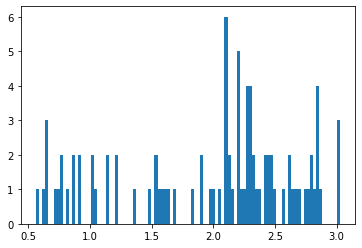

In [193]:
numberOfSims = 1 
endTime = 100 #years of simulation
ttor_masses = [['inner planet mass', 'outer planet mass','seed']]
BIGinitial = tiempo.time()
# try:
#     a = int(sys.argv[1])
# except IndexError:
#     print("#"*40)
#     print("\n"*3)
#     print("Sys.argv had an error! Setting the seed equal to 0!")
#     print("\n"*3)
#     print("#"*40)
a = 0
#
#for a in range(numberOfSims):
print("Beginning seed {}.".format(a))
sim = generatettor(simulation = ttor, seed =a, asteroidnumber = 100)
quickcollect2(n=2, Ti = 0 * tau, Tf=endTime * tau, stepnumber = 1000, asteroidCollect = True)
ps = sim.particles
print("Masses {} and {}.".format(ps[1].m,ps[2].m))
print("Ending seed {}.\n".format(a))
pre_list = [ps[1].m, ps[2].m,a]
ttor_masses.append(pre_list)
#
BIGfinal = tiempo.time()
totaltime = BIGfinal - BIGinitial
print("That in total took {} seconds ({} minutes).".format(int(totaltime), \
                                                           round(totaltime/60,2)))
#masslist_txt(ttor_masses,'test.txt','ttor','w')
print(ttor_masses)
print("There are {} particles remaining.".format(sim.N))
#ding()
# try:
# 	if int(sys.argv[2]): # sys.argv=0 will mean this is the first data point, =1 is last
# 		first = False
# 		last = True
# 	else: 
# 		first = True
# 		last = False
# except IndexError: # if first or last not specified, it is a middle data point
# 	first = False
# 	last = False
first = False
last = False
#masslist_txt_append(ttor_masses,'Masslists/shortTests.txt','ttor','a', first = first, last = last)
print(ttor_masses)
print("There are {} particles remaining.".format(sim.N))

saveFigs(addOn = "testy", seed = a, test = True)

In [ ]:
plt.clf()
plt.plot(times, asteroidEccs, linewidth=1)
plt.title('Asteroid Semi Major Axis Over Time')
plt.xlabel('Time (2pi*yr)')
plt.ylabel('Semi Major Axis (AU)')

(<Figure size 360x360 with 1 Axes>, <AxesSubplot:xlabel='x', ylabel='y'>)

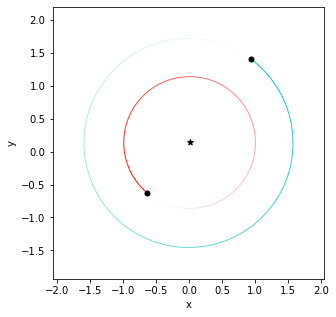

In [65]:
rebound.OrbitPlot(sim,color=True, plotparticles =[1,2])

(-0.3, 5.708196132237376)

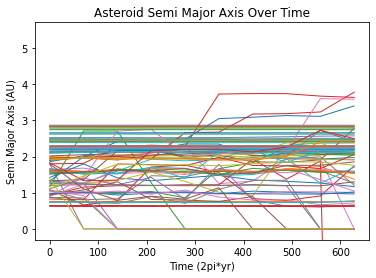

In [64]:
plt.clf()
plt.plot(times, asteroidAU, linewidth=1)
plt.title('Asteroid Semi Major Axis Over Time')
plt.xlabel('Time (2pi*yr)')
plt.ylabel('Semi Major Axis (AU)')
plt.ylim(bottom=-.3) # Only want to graph part of escaping asteroids

(-0.3, 5.0)

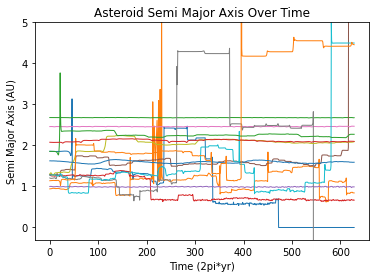

In [113]:
plt.clf()
plt.plot(times, asteroidAU[:,[i for i in range(0,simNi-2-1,75)]],linewidth=1)
plt.title('Asteroid Semi Major Axis Over Time')
plt.xlabel('Time (2pi*yr)')
plt.ylabel('Semi Major Axis (AU)')
plt.ylim(bottom=-.3, top = 5) # Only want to graph part of escaping asteroids

Text(0, 0.5, 'Semi Major Axis (AU)')

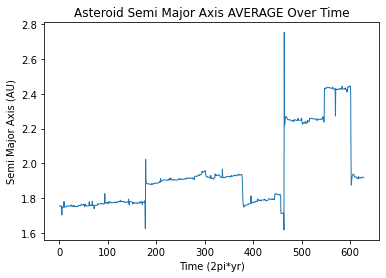

In [127]:
#asteroidAUaverage = [avg(asteroidAUList) for asteroidAUList in asteroidAU]
plt.plot(times, [avg(asteroidAUList) for asteroidAUList in asteroidAU],linewidth=1)
plt.title('Asteroid Semi Major Axis AVERAGE Over Time')
plt.xlabel('Time (2pi*yr)')
plt.ylabel('Semi Major Axis (AU)')
#plt.ylim(bottom=-.3, top = 5) # Only want to graph part of escaping asteroids

Text(0, 0.5, 'Semi Major Axis (AU)')

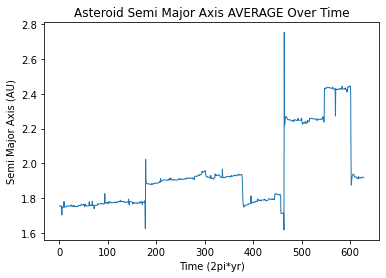

In [128]:
asteroidAUaverage = [avg(asteroidAUList) for asteroidAUList in asteroidAU]
plt.plot(times, asteroidAUaverage,linewidth=1)
plt.title('Asteroid Semi Major Axis AVERAGE Over Time')
plt.xlabel('Time (2pi*yr)')
plt.ylabel('Semi Major Axis (AU)')
#plt.ylim(bottom=-.3, top = 5) # Only want to graph part of escaping asteroids

In [125]:
asteroidAUaverage = [avg(asteroidAUList) for asteroidAUList in asteroidAU]
asteroidAUaverage

[1.7539550718996533,
 1.7544992524536742,
 1.755239623195961,
 1.7559502798611806,
 1.7531286523790737,
 1.7526580131690765,
 1.7525678768814894,
 1.7547633628149042,
 1.7027702263495537,
 1.749094184944965,
 1.7472937333852319,
 1.7461254095453584,
 1.7475861004603819,
 1.7484418128679562,
 1.7484636302171404,
 1.7797443813737717,
 1.7483939582882961,
 1.7483400885104028,
 1.7489681289518662,
 1.7478687649184106,
 1.7491008845567062,
 1.7496376355395826,
 1.7502797403058141,
 1.7513950883276754,
 1.7547387470509936,
 1.7538772900260868,
 1.7544325094355178,
 1.75396763712696,
 1.7541837774602835,
 1.7537147302487721,
 1.754167758640332,
 1.7544054024389963,
 1.7537489246922902,
 1.7541671387187536,
 1.754948272827158,
 1.7546418727955306,
 1.7579228372746731,
 1.7552301580397103,
 1.7542112767571283,
 1.7543609728585197,
 1.7610499194562714,
 1.7579800697838612,
 1.75335292778312,
 1.7509837253721487,
 1.7504533346362638,
 1.7526377812101785,
 1.7514879134898143,
 1.7530652775662916,


array([[2, 4],
       [7, 9]])

Text(0, 0.5, 'sim.N (AU)')

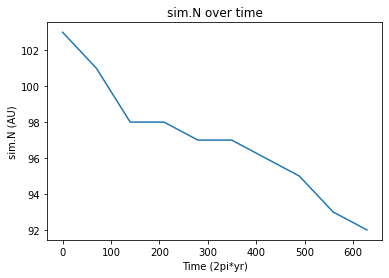

In [43]:
plt.clf()
plt.plot(times, particleNumber)
plt.title('sim.N over time')
plt.xlabel('Time (2pi*yr)')
plt.ylabel('sim.N (AU)')
plt.savefig("Figures/"+str(seed)+"/particleNumber"+addOn+".pdf")

In [134]:
def animate(N, T, sim): #this makes an animation of a system over time
    sim.integrate(0)
    interval = T/N
    from IPython.display import display, clear_output
    import matplotlib.pyplot as plt
    sim.move_to_com()
    end_timestep = N
    print ('The timestep is ', interval, 'years.')
    #stop = input('Is this suitable? (y/n)')
    #if stop == 'n':
        #sys.exit("Enter a higher N for a lower interval.")
    for i in range(N+1):
        sim.integrate(sim.t+interval)
        #fig, ax = rebound.OrbitPlot(sim,color=True,orbit_type='solid', unitlabel="[AU]",xlim=[-5,5],ylim=[-5,5])
        quickplot(sim)
        display()
        print (i, "timesteps,", i*interval, "years")
        print("The interval is", interval, 'years.')
        """if i == end_timestep/2:
            print("The current timestep is", i, ". This is a time of", i*interval,"years.")
            tf = input("Would you like to continue? (y/n)")
            if tf == 'n':
                break""" #I use these lines if I'm worried the total time is too high
        #plt.close(fig)
        plt.clf()
        clear_output(wait=True)
sim = generatettor(simulation = ttor,seed = None, asteroidnumber = 100)
animate(100,10, sim)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Text(0, 0.5, 'Eccentricity')

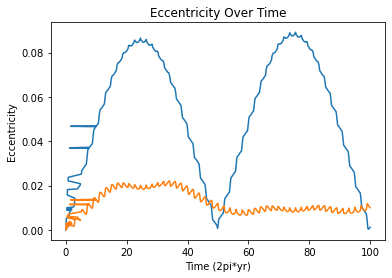

In [206]:
plt.clf()
plt.plot([i/tau for i in times], eccs)
plt.title('Eccentricity Over Time')
plt.xlabel('Time (2pi*yr)')
plt.ylabel('Eccentricity')